In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
codes = np.loadtxt(path/'codes.txt',dtype='str')

In [6]:
codes.shape,codes

((32,),
 array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'))

In [7]:
path_img = path/'images'
path_lbl = path/'labels'
path_img.ls()[:5],path_lbl.ls()[:5]

([PosixPath('/root/.fastai/data/camvid/images/0006R0_f02820.png'),
  PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01800.png'),
  PosixPath('/root/.fastai/data/camvid/images/0016E5_07965.png'),
  PosixPath('/root/.fastai/data/camvid/images/0016E5_06060.png'),
  PosixPath('/root/.fastai/data/camvid/images/0016E5_08087.png')],
 [PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00150_P.png'),
  PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01470_P.png'),
  PosixPath('/root/.fastai/data/camvid/labels/0006R0_f00960_P.png'),
  PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01260_P.png'),
  PosixPath('/root/.fastai/data/camvid/labels/0016E5_05520_P.png')])

In [0]:
val = np.loadtxt(path/'valid.txt',dtype='str')

In [9]:
df = pd.DataFrame(val)
df.head()

,0
0,0016E5_07959.png
1,0016E5_07961.png
2,0016E5_07963.png
3,0016E5_07965.png
4,0016E5_07967.png


In [0]:
def y_func(x): return path_lbl/f'{x.stem}_P{x.suffix}'

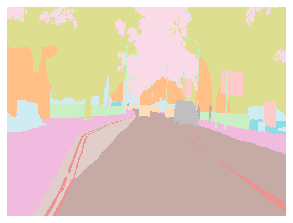

In [11]:
mask = path_lbl.ls()[0]
mask = open_mask(mask)
mask.show(figsize=(5,5))

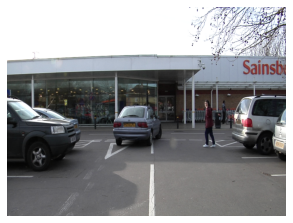

In [12]:
img_sam = path_img.ls()[0]
img = open_image(img_sam)
img.show(figsize=(5,5))

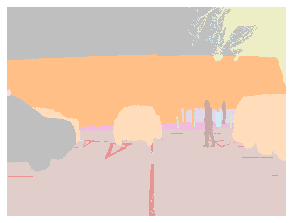

In [13]:
mask_sam = y_func(img_sam)
mask = open_mask(mask_sam)
mask.show(figsize=(5,5))



In [14]:
size = np.array(mask.shape[1:])
src_size = size//2
src_size,size

(array([360, 480]), array([720, 960]))

In [0]:
src = SegmentationItemList.from_folder(path_img).split_by_files(valid_names = val).label_from_func(y_func,classes=codes)

In [0]:
def get_data(size,bs):
  return src.transform(get_transforms(),size=size,tfm_y=True).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
data =  get_data(src_size,bs=8)

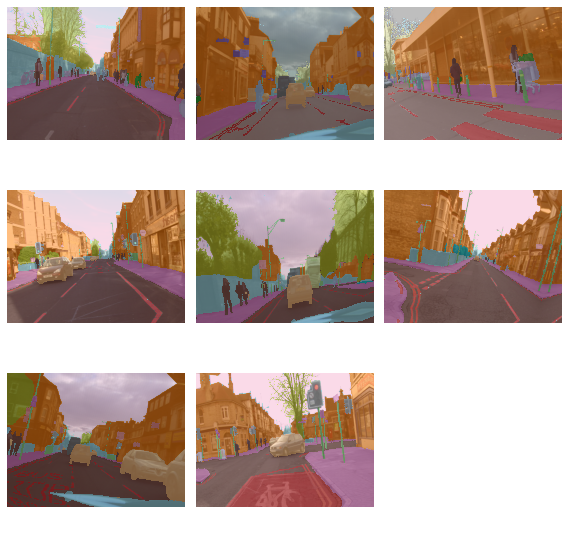

In [17]:
data.show_batch(3,figsize=(8,8))

In [0]:
name2id = {a:b for b,a in enumerate(codes)}
void = name2id['Void']
def acc_camvid(input,target):
  target = target.squeeze(1)
  mask = target != void
  return (input.argmax(1)[mask] == target[mask]).float().mean()

metrics = acc_camvid

In [0]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=1e-02)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


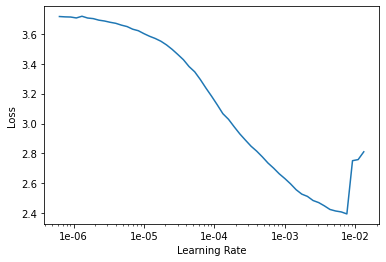

In [20]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(10,slice(1e-03))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.540103,0.836889,0.808295,01:27
1,0.919488,0.645319,0.842403,01:26
2,0.765049,0.621233,0.827510,01:26
3,0.636708,0.486660,0.866459,01:25
4,0.548099,0.466375,0.871945,01:25
5,0.496206,0.451058,0.866094,01:26
6,0.445545,0.362850,0.890568,01:25
7,0.400670,0.355774,0.888741,01:25
8,0.364048,0.310876,0.909805,01:25
9,0.342447,0.302332,0.911743,01:26


In [0]:
learn.save('small')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


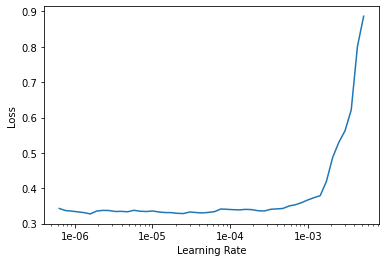

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(8,slice(4e-06,4e-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.338935,0.308027,0.913460,01:30
1,0.364987,0.320772,0.912446,01:30
2,0.363184,0.311691,0.913861,01:29
3,0.340409,0.300606,0.914682,01:29
4,0.313766,0.281981,0.918358,01:30
5,0.281183,0.279070,0.920331,01:29
6,0.263053,0.282693,0.918782,01:30
7,0.254290,0.278802,0.919091,01:30


In [0]:
learn.save('small')

In [0]:
data = get_data(size,bs=3)

In [0]:
learn.destroy()

In [0]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=1e-02)

In [0]:
learn.load('small')

In [0]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(8,1e-03)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406232,0.383398,0.894483,06:06
1,0.513096,0.592615,0.864203,06:00
2,0.465519,0.349553,0.916383,05:56
3,0.386048,0.338773,0.911243,05:56
4,0.331744,0.305107,0.918462,05:56
5,0.282598,0.263585,0.926240,05:56
6,0.256987,0.249860,0.928281,05:56
7,0.228720,0.246487,0.929830,05:56


In [0]:
learn.save('Big')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


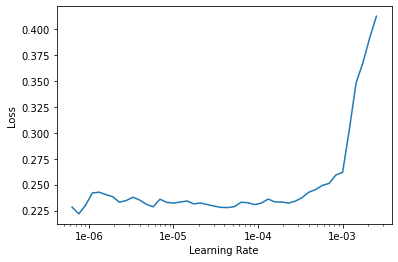

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8,slice(2e-06,1e-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.222301,0.258042,0.927304,06:09
1,0.225591,0.270323,0.920559,06:09
2,0.215270,0.243015,0.931721,06:09
3,0.216047,0.236567,0.932353,06:09
4,0.202590,0.242313,0.932360,06:09
5,0.199251,0.238698,0.933888,06:09
6,0.186934,0.238921,0.933913,06:09
7,0.196633,0.240586,0.933137,06:10


In [30]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05